In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [19]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

assert(tf.executing_eagerly())
print('TF version: ', tf.__version__)
print('TFP version: ', tfp.__version__)

This is one of the tutorials from Bayesian Probabilistic Method for Hackers, with data now using the NAO storms instead of text messaging. We still copy all the text and experiments though.

## Poisson distribution
### Discrete case
If a random variable $Z$ is discrete, then its distribution is called a *probability mass function*, which measures the probability $Z$ takes on the value $k$, denoted by $P(Z=k)$. Note that the probability mass function completely describes the random variable $Z$, that is, if we know the mass function, we know how $Z$ should behave. There are popular probability mass functions that consistently appear: Let's introduce the first very useful PMF. We say that $Z$ is *Poisson* distributed if 

$$
P(Z=k) = \frac{\lambda^k e^{-\lambda}}{k!},\, k = 0, 1, 2,\ldots
$$

$\lambda$ is called a parameter of the distribution, and it controls the distribution's shape. For the Poisson distribution, $\lambda$ can be any positive number. By increasing $\lambda$, we add more probability to larger values, and conversely by decreasing $\lambda$ we add more probability to smaller values. One can describe $\lambda$ as the *intensity* of the Poisson distribution.

Unlike $\lambda$, which can be any positive number, the value $k$ in the above formula must be a non-negative integer, i.e. $k$ must take on values of 0, 1, 2 and so on. This is very important, because if you want to model a population you cannot make sense of populations with 4.25 or 5.612 members.

If a random variable $Z$ has a Poisson mass distribution, we denote this by writing

$$
Z\sim \mathrm{Poi}(\lambda)
$$

One useful property of the Poisson distribution is that its expected value is equal to its parameter, i.e.

$$
E[Z |\lambda] = \lambda
$$

We will use this property often.
### Continuous case
Instead of a probability mass function, a continuous random variable has a *probability density function*. An example of continuous random variable is a random variable with *exponential density*. The density function for an exponential random variable looks like this:

$$
f_Z(z|\lambda) = \lambda e^{-\lambda z},\,z\ge 0
$$

Like a Poisson random variable, an exponential random variable can only take on non-negative values. But unlike a Poisson variable, the exponential can take on any non-negative values. This makes it a poor choice for count data but a great choice for time data, temperature data or any other precise and *positive* variable.

In [14]:
tfd = tfp.distributions
tfb = tfp.bijectors

## Example: inferring behaviour from text-message data

In [31]:
import pandas as pd

# www.ncdc.noaa.gov/ibtracs/index.php?name=wmo-data
df = pd.read_csv('https://github.com/ipython-books/'
    'cookbook-2nd-data/blob/master/'
    'Allstorms.ibtracs_wmo.v03r05.csv?'
    'raw=true',
    delim_whitespace=False)

cnt = df[df['Basin'] == ' NA'].groupby('Season')['Serial_Num'].nunique()
# The years from 1851 to 2012
years = cnt.index
y0, y1 = years[0], years[-1]
arr = cnt.values

In [32]:
count_data = tf.constant(arr, dtype=tf.float32)
n_count_data = tf.shape(count_data)
years = tf.constant(years)

In [33]:
[
    count_data_,
    n_count_data_,
    years_,
] = evaluate([
    count_data,
    n_count_data,
    years,
])

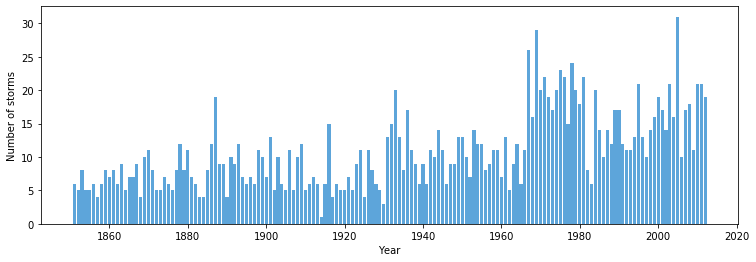

In [35]:
plt.figure(figsize=(12.5, 4))
plt.bar(years_, count_data_, color='#5DA5DA')
plt.xlabel('Year')
plt.ylabel('Number of storms');

How can we start to model this? Well, as we have conveniently already seen, a Poisson random variable is a very appropriate model for this type of *count* data. Denoting year $i$'s storm count by $C_i$,

$$
C_i\sim \mathrm{Poisson}(\lambda)
$$

We are not sure what the value of the $\lambda$ parameter really is, however. Looking at the chart above, it appears that the rate might become higher later in the observation period, which is equivalent to saying $\lambda$ increases at some point during the observations. (Recall that a higher value of $\lambda$ assigns more probability to larger outcomes. That is, there is a higher probability of many storms in that year).

How can we represent this observation mathematically? Let's assume that for some year during the observation period (call it $\tau$), the parameter $\lambda$ suddenly jumps to a higher value. So we really have two $\lambda$ parameters: one for the period before $\tau$, and one for the rest of the observation period. In literature, a sudden transition like this would be called a *switchpoint*:

$$
\lambda = \begin{cases}\lambda_1 & \text{if } t \lt \tau, \\
\lambda_2 & \text{if } t \ge \tau
\end{cases}
$$

If in reality no sudden change occurred and indeed $\lambda_1 = \lambda_2$, then the $\lambda$s posterior distributions should look about equal.

We are interested in inferring the unknown $\lambda$s. To use Bayesian inference, we need to assign prior probabilities to the different possible values of $\lambda$. What would be good prior probability distributions for $\lambda_1$ and $\lambda_2$? Recall that $\lambda$ can be any positive number. As we saw earlier, the *exponential* distribution provides a continuous density function for positive numbers, so it might be a good choice for modelling $\lambda_i$. But recall that the exponential distribution takes a parameter of its own, so we'll need to include that parameter in our model. Let's call that parameter $\alpha$.

$$
\lambda_1 \sim\mathrm{Exp}(\alpha) \\
\lambda_2 \sim\mathrm{Exp}(\alpha)
$$

$\alpha$ is called a *hyper-parameter* or *parent variable*. In literal terms, it is a parameter that influences other parameters. Our initial guess at $\alpha$ does not influence the model too strongly, so we have some flexibility in our choice. A good rule of thumb is to set the exponential parameter equal to the inverse of the average of the count data. Since we are modelling $\lambda$ using an exponential distribution, we can use the expected value identity shown earlier to get:

$$
\frac{1}{N}\sum_{i=0}^N C_i\approx E[\lambda|\alpha] = \frac{1}{\alpha}
$$

What about $\tau$? Because of the noisiness of the data, it's difficult to pick out a priori when $\tau$ might have occurred. Instead, we can assign a *uniform prior belief* to every possible year. This is equivalent to saying 

$$
\tau\sim \mathrm{DiscreteUniform}(1, 162) \\
\rightarrow P(\tau = k) = \frac{1}{70}
$$
So after all this, what does our overall prior distribution for the unknown variable look like? Frankly, *it doesn't matter*. All we really care about is the posterior distribution.

## Probabilistic Programming
B. Cronin has a very motivating description of probabilistic programming:
>Another way of thinking about this: unlike a traditional program, which only runs in the forward directions, a probabilistic program is run in both the forward and backward direction. It runs forward to compute the consequences of the assumptions it contains about the world (i.e., the model space it represents), but it also runs backward from the data to constrain the possible explanations. In practice, many probabilistic programming systems will cleverly interleave these forward and backward operations to efficiently home in on the best explanations.

### Tensorflow Probability: Specify the joint log-density.
We are representing the model's components $(\tau,\lambda_1,\lambda_2)$ as variables.

We'll assume the data is a consequence of the following generative model:
$$
\lambda_1^{(0)} \sim\mathrm{Exponential}(\mathrm{rate} = \alpha) \\
\lambda_2^{(0)} \sim \mathrm{Exponential}(\mathrm{rate} = \alpha) \\
\tau \sim\mathrm{Uniform}[\mathrm{low}=0,\mathrm{high}=1)
$$

$$
\mathrm{for}\,i=1,\ldots,N: 
$$

$$
\lambda_i = \begin{cases}\lambda_1^{(0)}, & \tau\lt i/N \\
\lambda_2^{(0)}, & \text{otherwise}
\end{cases}
$$

$$
X_i\sim\text{Poisson(rate}=\lambda_i)
$$

This code creates a new function `lambda_`, but really we can think of it as a random variable: the random variable $\lambda$ from above. The `gather` function assigns `lambda_1` or `lambda_2` as the value of `lambda_`, depending on what side of `tau` we are on. THe values of `lambda_` up until `tau` are `lambda_1` and the values afterwards are `lambda_2`.

Note that because `lambda_1`, `lambda_2` and `tau` are random, `lambda_` will be random. We are **not** fixing any variables yet.

TFP performs probabilistic inference by evaluating the model parameters using a joint_log_prob function.

### Specify the posterior sampler
Markov Chain Monte Carlo (MCMC)

In [54]:
# Set the chains's start state
initial_chain_state = [
    tf.cast(tf.reduce_mean(count_data), tf.float32) * tf.ones([], dtype=tf.float32, name='init_lambda1'),
    tf.cast(tf.reduce_mean(count_data), tf.float32) * tf.ones([], dtype=tf.float32, name='init_lambda2'),
    0.5 * tf.ones([], dtype=tf.float32, name='init_tau'),
]

In [55]:
# Since HMC operates over unconstrained space, we need to transform the 
# samples so they live in real space.
unconstraining_bijectors = [
    tfp.bijectors.Exp(), # Maps a positive real to R.
    tfp.bijectors.Exp(), # Maps a positive real to R.
    tfp.bijectors.Sigmoid(), # Maps [0, 1] to R.
]

In [67]:
def joint_log_prob(count_data, lambda_1, lambda_2, tau):
    tfd = tfp.distributions
 
    alpha = (1. / tf.reduce_mean(count_data))
    rv_lambda_1 = tfd.Exponential(rate=alpha)
    rv_lambda_2 = tfd.Exponential(rate=alpha)
 
    rv_tau = tfd.Uniform()
 

    lambda_ = tf.gather(
         [lambda_1, lambda_2],
         indices=tf.cast(tau * tf.cast(tf.size(count_data), tf.float32) <= tf.cast(tf.range(tf.size(count_data)), tf.float32), tf.int32))
    rv_observation = tfd.Poisson(rate=lambda_)
 
    return (
         rv_lambda_1.log_prob(lambda_1)
         + rv_lambda_2.log_prob(lambda_2)
         + rv_tau.log_prob(tau)
         + tf.reduce_sum(rv_observation.log_prob(count_data))
    )

In [56]:
# Define a closure over our joint_log_prob.
def unnormalized_log_posterior(lambda1, lambda2, tau):
    return joint_log_prob(count_data, lambda1, lambda2, tau)

In [57]:
step_size = tf.Variable(tf.constant(0.05, dtype=tf.float32), name='step_size', trainable=False)

Very nasty change here where you have to use several layers of kernels.

In [102]:
num_results=5000
num_burnin_steps=500

kernel = tfp.mcmc.TransformedTransitionKernel(
        tfp.mcmc.HamiltonianMonteCarlo(
            target_log_prob_fn=unnormalized_log_posterior,
            num_leapfrog_steps=2,
            step_size=0.1),
        bijector=unconstraining_bijectors)

adapt_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
    inner_kernel=kernel,
    num_adaptation_steps=int(num_burnin_steps*0.8))

[
    lambda_1_samples,
    lambda_2_samples,
    posterior_tau,
], kernel_results = tfp.mcmc.sample_chain(
    num_results=num_results,
    num_burnin_steps=num_burnin_steps,
    current_state=initial_chain_state,  
    kernel = adapt_hmc
)

tau_samples = tf.floor(posterior_tau * tf.cast(tf.size(count_data), tf.float32), tf.float32)

/home/yl238/projects/python-extras/.env/lib/python3.7/site-packages/tensorflow_probability/python/mcmc/sample.py:336: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn("Tracing all kernel results by default is deprecated. Set "


In [90]:
def evaluate(tensors):
    """Evaluates Tensor or EagerTensor to Numpy `ndarray`s.
    Args:
    tensors: Object of `Tensor` or EagerTensor`s; can be `list`, `tuple`,
      `namedtuple` or combinations thereof.
 
    Returns:
      ndarrays: Object with same structure as `tensors` except with `Tensor` or
        `EagerTensor`s replaced by Numpy `ndarray`s.
    """
    if tf.executing_eagerly():
        return tf.nest.pack_sequence_as(
            tensors,
            [t.numpy() if tf.is_tensor(t) else t
             for t in tf.nest.flatten(tensors)])
    return sess.run(tensors)

In [119]:
# tau_samples, lambda_1_samples, lambda_2_samples contain
# N samples from the corresponding posterior distribution
N = tf.shape(tau_samples)[0]
expected_storms_per_year = tf.zeros(n_count_data)

In [120]:
[
    lambda_1_samples_,
    lambda_2_samples_,
    tau_samples_,
    kernel_results_,
    N_,
    expected_storms_per_year_,
] = evaluate([
    lambda_1_samples,
    lambda_2_samples,
    tau_samples,
    kernel_results,
    N,
    expected_storms_per_year,
])

    
print("acceptance rate: {}".format(
    kernel_results_.inner_results.inner_results.is_accepted.mean()))

acceptance rate: 0.4866


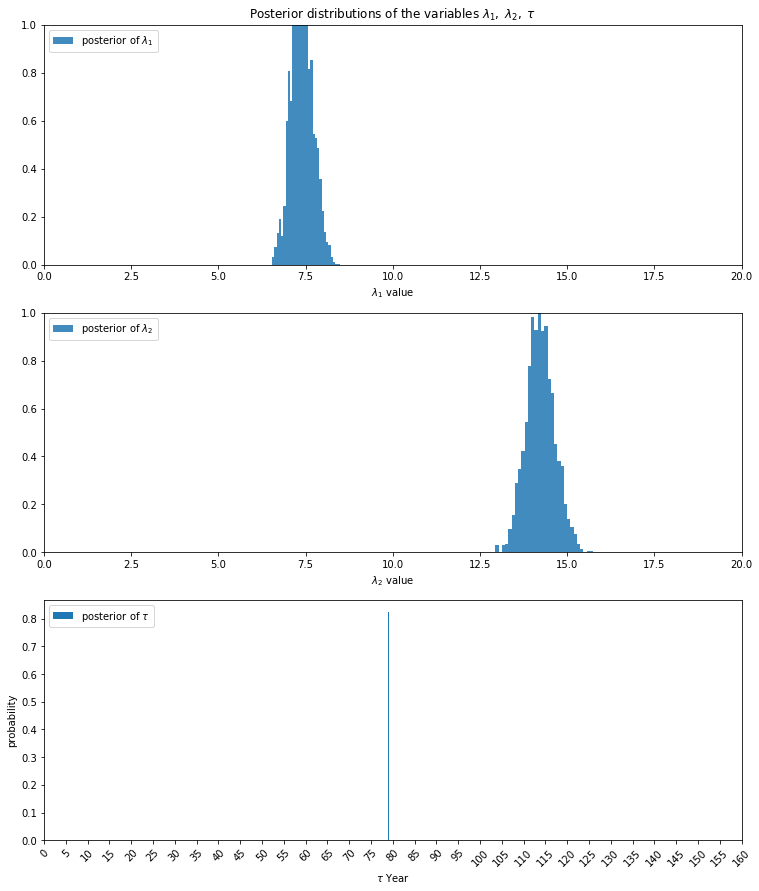

In [126]:
plt.figure(figsize=(12.5, 15))
#histogram of the samples:

ax = plt.subplot(311)
ax.set_autoscaley_on(False)

plt.hist(lambda_1_samples_, histtype='stepfilled', bins=30, alpha=0.85,
         label=r"posterior of $\lambda_1$",  density=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables $\lambda_1,\;\lambda_2,\;\tau$""")
plt.xlim([0, 20])
plt.xlabel(r"$\lambda_1$ value")

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples_, histtype='stepfilled', bins=30, alpha=0.85,
         label=r"posterior of $\lambda_2$", density=True)
plt.legend(loc="upper left")
plt.xlim([0, 20])
plt.xlabel(r"$\lambda_2$ value")

plt.subplot(313)
w = 1.0 / tau_samples_.shape[0] * np.ones_like(tau_samples_)
plt.hist(tau_samples_, bins=n_count_data_[0], alpha=1,
         label=r"posterior of $\tau$",
         weights=w, rwidth=2.)
plt.xticks(np.arange(n_count_data_[0]/5)*5, rotation=45)

plt.legend(loc="upper left")

plt.xlabel(r"$\tau$ Year")
plt.ylabel(r"probability");

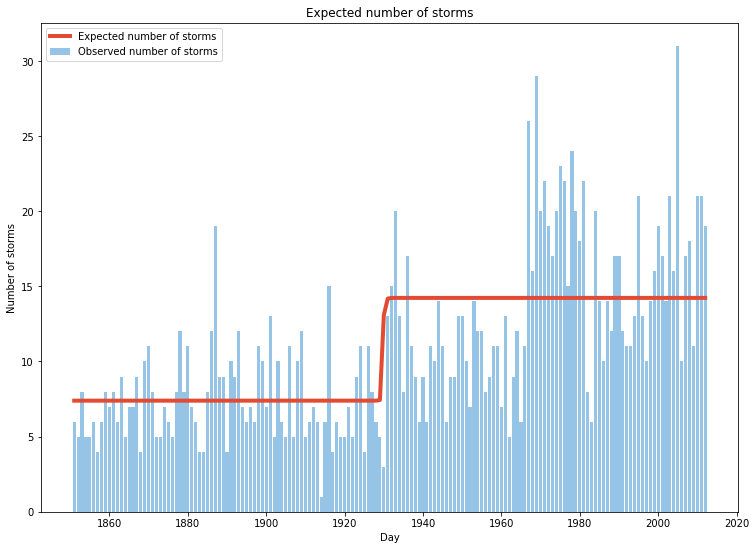

In [125]:
plt.figure(figsize=(12.5, 9))

for day in range(0, n_count_data_[0]):
    # ix is a bool index of all tau samples corresponding to
    # the switchpoint occurring prior to value of 'day'
    ix = day < tau_samples_
    # Each posterior sample corresponds to a value for tau.
    # for each day, that value of tau indicates whether we're "before"
    # (in the lambda1 "regime") or
    #  "after" (in the lambda2 "regime") the switchpoint.
    # by taking the posterior sample of lambda1/2 accordingly, we can average
    # over all samples to get an expected value for lambda on that day.
    # As explained, the "message count" random variable is Poisson distributed,
    # and therefore lambda (the poisson parameter) is the expected value of
    # "message count".
    expected_storms_per_year_[day] = (lambda_1_samples_[ix].sum()
                                   + lambda_2_samples_[~ix].sum()) / N_


plt.plot(years_, expected_storms_per_year_, lw=4, color="#E24A33",
         label="Expected number of storms")
#plt.xlim(0, n_count_data_[0])
plt.xlabel("Day")
plt.ylabel("Number of storms")
plt.title("Expected number of storms")
plt.bar(years_, count_data_, color="#5DA5DA", alpha=0.65,
        label="Observed number of storms")

plt.legend(loc="upper left");